## Produce blanc n(z) for ELGs

In [1]:
#- Basic imports
%pylab inline

import sys, os, glob
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import fitsio
from astropy.table import Table
#from desitarget.cmx.cmx_targetmask import cmx_mask
from desitarget.targets import desi_mask
from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, mws_mask
from desiutil.dust import mwdust_transmission

Populating the interactive namespace from numpy and matplotlib


In [2]:
#global variables
fs = 20 #fontsize

Locating files

In [3]:
specprod = 'blanc'
specprod_dir = f'/global/cfs/cdirs/desi/spectro/redux/{specprod}'
sv1all = fitsio.read(specprod_dir + '/zcatalog-blanc-sv1all.fits')

condition for selecting ELGs; select galaxies with ZWARN ==0 and the appropriate ELG bit

In [4]:
#list of tiles from https://data.desi.lbl.gov/desi/users/raichoor/fiberassign-sv1/sv1-per-tile/
pure_elg_tiles = np.array([80606, 80608, 80610, 80621, 80623])
qso_elg_tiles = np.arange(80667, 80711, 2)

In [7]:
targetids, ii = np.unique(sv1all['TARGETID'], return_index=True)
if len(targetids) < len(sv1all):
    sv1all = sv1all[ii]
    
targetcol = 'SV1_DESI_TARGET'
elgMask = desi_mask.mask('ELG_FDR_GFIB')

desi_target = sv1all[targetcol]
isGal = (sv1all['SPECTYPE'] == 'GALAXY')
isRedshift = (sv1all['ZWARN'] == 0)
isDeltaChi2_25 = (sv1all['DELTACHI2'] >= 25) #to select objects with SNR >= 5
isELGonlyTile = (sv1all['TILEID'] == 80606) | (sv1all['TILEID'] == 80608) | (sv1all['TILEID'] == 80610) | (sv1all['TILEID'] == 80621) | (sv1all['TILEID'] == 80623) #select ELG target tiles only

#apply flags
istotalELG = isGal & ((desi_target & elgMask) != 0) & isELGonlyTile
isGoodRedzELG = istotalELG & isRedshift
isGoodZChi2ELG = isGoodRedzELG & isDeltaChi2_25
isNoRedzELG = istotalELG & (~isRedshift)
#isGoodRedzELG = isGal & isRedshift & ((desi_target & elgMask) != 0) & isELGonlyTile
#isNoRedzELG = isGal & (~isRedshift) & ((desi_target & elgMask) != 0) & isELGonlyTile

Which `TILEID` are contributing to the n(z) mesurement

In [8]:
np.unique(sv1all[isGoodRedzELG]['TILEID'])

array([80606, 80608, 80610, 80621, 80623], dtype=int32)

## Q1: What fraction of ELGs did not get a redshift measurement (ZWARN != 0) ?

In [9]:
f_bad = np.sum(isNoRedzELG)/np.sum(istotalELG)
f_good = np.sum(isGoodRedzELG)/np.sum(istotalELG)
f_good_chi2 = np.sum(isGoodZChi2ELG)/np.sum(istotalELG)

In [10]:
print(f'fraction of ELGs without redshift: {np.round(f_bad, 3)}')
print(f'fraction of ELGs with redshift: {np.round(f_good, 3)}')
print(f'fraction of ELGs with redshift and DeltaChi2 >= 25: {np.round(f_good_chi2, 3)}')

fraction of ELGs without redshift: 0.061
fraction of ELGs with redshift: 0.939
fraction of ELGs with redshift and DeltaChi2 >= 25: 0.898


## Q2: Where do ELGs with (ZWARN != 0) reside in the $(g - r)$ vs. $(r - z)$ space?

Calculate the Milky Way dust transmission for all the ELGs

In [11]:
mw_transmission_g = np.zeros(len(sv1all))
mw_transmission_r = np.zeros(len(sv1all))
mw_transmission_z = np.zeros(len(sv1all))

for i in range(len(sv1all)):
    if(sv1all['PHOTSYS'][i] == ''): #these are OBJTYPE == BAD or SKY. Only 549 are TGT in the M33 + Dark tile as Anand mentioned
        mw_transmission_g[i] = mwdust_transmission(sv1all['EBV'][i], 'G', 'N')
        mw_transmission_r[i] = mwdust_transmission(sv1all['EBV'][i], 'R', 'N')
        mw_transmission_z[i] = mwdust_transmission(sv1all['EBV'][i], 'Z', 'N')
    else:
        mw_transmission_g[i] = mwdust_transmission(sv1all['EBV'][i], 'G', sv1all['PHOTSYS'][i])
        mw_transmission_r[i] = mwdust_transmission(sv1all['EBV'][i], 'R', sv1all['PHOTSYS'][i])
        mw_transmission_z[i] = mwdust_transmission(sv1all['EBV'][i], 'Z', sv1all['PHOTSYS'][i])

In [12]:
#from https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SurveyValidation 
#NOT CORRECTED FOR MW_TRANSMISSION beause not provided in the blanc file
gr = -2.5*np.log10((sv1all['FLUX_G']/mw_transmission_g)/(sv1all['FLUX_R']/mw_transmission_r))
rz = -2.5*np.log10((sv1all['FLUX_R']/mw_transmission_r)/(sv1all['FLUX_Z']/mw_transmission_z)) 

<ipython-input-12-8a606950bcc5>:3: RuntimeWarning: divide by zero encountered in true_divide
  gr = -2.5*np.log10((sv1all['FLUX_G']/mw_transmission_g)/(sv1all['FLUX_R']/mw_transmission_r))
<ipython-input-12-8a606950bcc5>:3: RuntimeWarning: invalid value encountered in true_divide
  gr = -2.5*np.log10((sv1all['FLUX_G']/mw_transmission_g)/(sv1all['FLUX_R']/mw_transmission_r))
<ipython-input-12-8a606950bcc5>:3: RuntimeWarning: divide by zero encountered in log10
  gr = -2.5*np.log10((sv1all['FLUX_G']/mw_transmission_g)/(sv1all['FLUX_R']/mw_transmission_r))
<ipython-input-12-8a606950bcc5>:3: RuntimeWarning: invalid value encountered in log10
  gr = -2.5*np.log10((sv1all['FLUX_G']/mw_transmission_g)/(sv1all['FLUX_R']/mw_transmission_r))
<ipython-input-12-8a606950bcc5>:4: RuntimeWarning: divide by zero encountered in true_divide
  rz = -2.5*np.log10((sv1all['FLUX_R']/mw_transmission_r)/(sv1all['FLUX_Z']/mw_transmission_z))
<ipython-input-12-8a606950bcc5>:4: RuntimeWarning: invalid value enco

In [13]:
#DEFINE FDR CUT FOR PLOTTING PURPOSES ACCORDING TO https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SurveyValidation 

def fdr_plot():
    #rz 0.3 cut 
    rz3_x = .3 * np.ones(10)
    rz3_y = np.linspace(-.5, .2, 10)
    
    #rz 1.6 cut
    rz16_x = 1.6 * np.ones(100)
    rz16_y = np.linspace(-.5, -.32, 100)
    
    #star/lowz cut
    lowz_x = np.arange(0.3, .75 + .01, .01)
    lowzSouth_y = 1.15 * lowz_x -.15
    lowzNorth_y = 1.15 * lowz_x -.20
    
    # [O II] cut
    OIIx = np.arange(.75, 1.6, .01)
    OIIy = -1.2 * OIIx + 1.6
    
    plt.plot(rz3_x, rz3_y, c = 'k')
    plt.plot(rz16_x, rz16_y, c = 'k')
    plt.plot(OIIx, OIIy, c = 'g', label = '[O II] cut')
    plt.plot(lowz_x, lowzNorth_y, c = 'r', label = 'lowz North cut')
    plt.plot(lowz_x, lowzSouth_y, c = 'r', ls = "--", label = 'lowz South cut')
    plt.legend(loc = 'best')

(-0.5, 1.0)

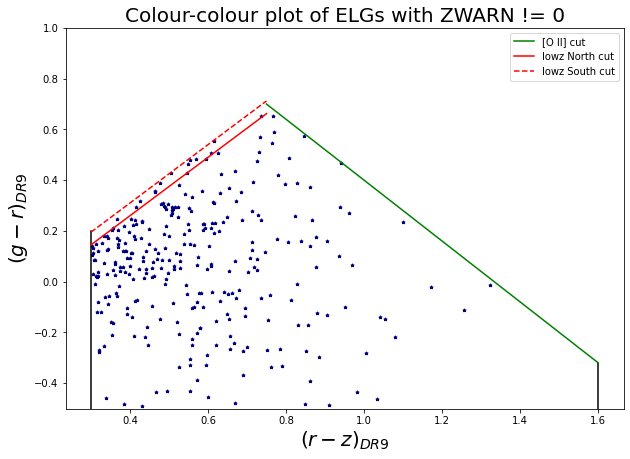

In [19]:
plt.figure(figsize=(10, 7))
fdr_plot()
plt.scatter(rz[isNoRedzELG], gr[isNoRedzELG], marker = "*", s = 10, c = 'navy')
plt.ylabel(r"$(g - r)_{DR9}$", fontsize = fs)
plt.xlabel(r"$(r - z)_{DR9}$", fontsize = fs)
plt.title("Colour-colour plot of ELGs with ZWARN != 0", fontsize = fs)
plt.ylim([-.5, 1])

## Q3: Where do the low redshift ELGs (ZWARN == 0 & Z < 0.6) reside in the $(g - r)$ vs. $(r - z)$ space?

In [15]:
# select lowz ELGs
islowzELG = isGoodRedzELG & (sv1all['Z'] < 0.6)

(-0.5, 1.0)

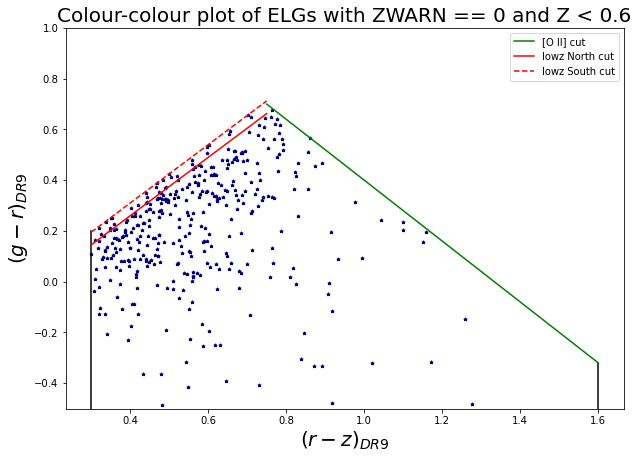

In [18]:
plt.figure(figsize=(10, 7))
fdr_plot()
plt.scatter(rz[islowzELG], gr[islowzELG], marker = "*", s = 10, c = 'navy')
plt.ylabel(r"$(g - r)_{DR9}$", fontsize = fs)
plt.xlabel(r"$(r - z)_{DR9}$", fontsize = fs)
plt.legend(loc = 'best')
plt.title("Colour-colour plot of ELGs with ZWARN == 0 and Z < 0.6", fontsize = fs)
plt.ylim([-.5, 1])

## Q4: Where are low SNR ELGs ($\Delta \chi^2$) with ZWARN == 0 reside in the $(g - r)$ vs. $(r - z)$ space?

In [22]:
islowSNR = isGoodRedzELG & (~isGoodZChi2ELG)
print(f"% of objects with Delta Chi2 < 25: {np.sum(islowSNR)/np.sum(istotalELG)}")

% of objects with Delta Chi2 < 25: 0.0406891495601173


(-0.5, 1.0)

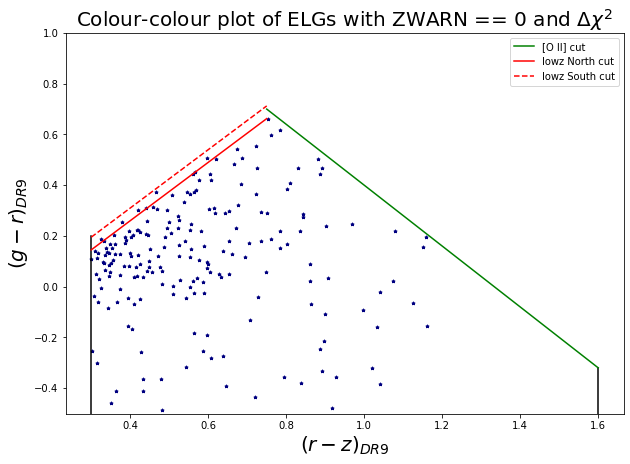

In [21]:
plt.figure(figsize=(10, 7))
fdr_plot()
plt.scatter(rz[islowSNR], gr[islowSNR], marker = "*", s = 10, c = 'navy')
plt.ylabel(r"$(g - r)_{DR9}$", fontsize = fs)
plt.xlabel(r"$(r - z)_{DR9}$", fontsize = fs)
plt.legend(loc = 'best')
plt.title(r"Colour-colour plot of ELGs with ZWARN == 0 and $\Delta \chi^2$", fontsize = fs)
plt.ylim([-.5, 1])

## Addendum: Where do all the good ELGs (ZWARN == 0 & Z >= 0.6) reside in the $(g - r)$ vs. $(r - z)$ space?

In [23]:
# select lowz ELGs
#isgoodELG = isGoodRedzELG & (sv1all['Z'] >= 0.6)
isgoodELG = isGoodZChi2ELG & (sv1all['Z'] >= 0.6)

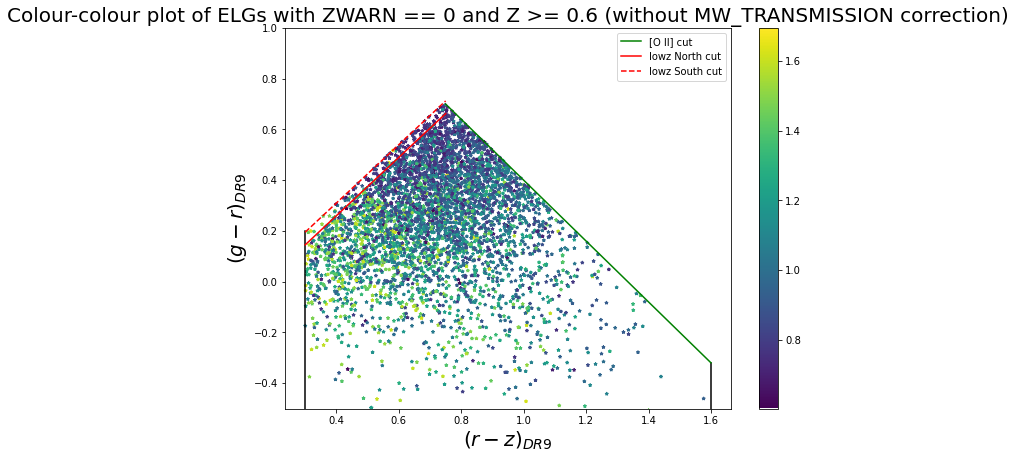

In [24]:
plt.figure(figsize=(10, 7))
fdr_plot()
plt.scatter(rz[isgoodELG], gr[isgoodELG], c = sv1all[isgoodELG]['Z'], marker = "*", s = 10)
plt.ylabel(r"$(g - r)_{DR9}$", fontsize = fs)
plt.xlabel(r"$(r - z)_{DR9}$", fontsize = fs)
plt.legend(loc = 'best')
plt.title("Colour-colour plot of ELGs with ZWARN == 0 and Z >= 0.6 (without MW_TRANSMISSION correction)", fontsize = fs)
plt.ylim([-.5, 1])
#plt.ylim([-.2, .4])
#plt.xlim([.2, .8])
plt.colorbar()

## Q4: What is the n(z) of the $5$ pure ELG tiles?

Number of ELGs with good redshifts: 4902


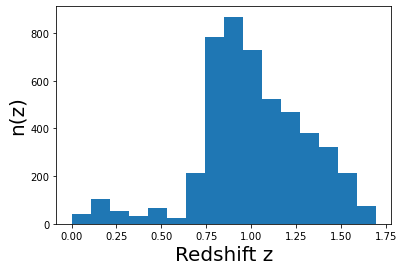

In [28]:
bins = 16
#zelg = sv1all[isGoodRedzELG]['Z']
zelg = sv1all[isGoodZChi2ELG]['Z']
print(f'Number of ELGs with good redshifts: {zelg.shape[0]}')

plt.xlabel("Redshift z", fontsize = fs)
plt.ylabel("n(z)", fontsize = fs)
plt.hist(zelg, bins = bins);

In [29]:
zelg[zelg < 0]

array([-0.00050072])

In [34]:
sv1all[isGoodZChi2ELG][zelg < 0]['TARGETID']

array([39632940363154450])

**Note:** There are at least two ELGs with ZWARN == 0 but Z < 0. What is wrong with them?

### Convert n(z) to p(z) while taking into account that $\int p(z) dz = f_{good}$ because we must account for ELGs that do not have a redshift measurement. 

Text(0, 0.5, 'p(z)')

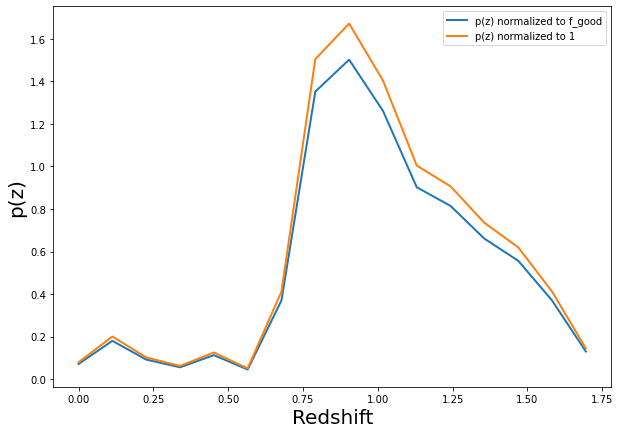

In [37]:
#crude estimation using numpy
pz_full, bin_ledge = np.histogram(zelg, bins=bins, density=True) #usual pz normalized to 1
weights_fgood = np.ones(len(zelg)) * 1/(np.diff(bin_ledge)[0] * len(zelg)) * f_good_chi2 #weights to normalize to f_good
pz_good, _ = np.histogram(zelg, bins=bins, weights = weights_fgood) #convert n(z) to p(z) normalized to f_good 
centr_z = np.linspace(bin_ledge[0], bin_ledge[0] + np.ediff1d(bin_ledge)[0] * (len(bin_ledge) - 1), len(bin_ledge) - 1) #find the central values of the histograms for plotting purposes

plt.figure(figsize=(10,7))
plt.plot(centr_z, pz_good, label = 'p(z) normalized to f_good', lw = 2)
plt.plot(centr_z, pz_full, label = 'p(z) normalized to 1', lw = 2)
#plt.hist(zelg, bins = 100, histtype= 'step', alpha = 0.6, color = 'darkgreen', lw = 1.5, density = True);
plt.legend(loc = 'best')
plt.xlabel("Redshift", fontsize = fs)
plt.ylabel("p(z)", fontsize = fs)

### Check integration of the histograms to make sure they are normalized properly

In [38]:
print(f'Integral under the normalized to 1 curve: {sp.integrate.trapz(pz_full, centr_z, dx = np.ediff1d(centr_z)[0])}')
print(f'Integral under the normalized to f_good curve: {sp.integrate.trapz(pz_good, centr_z, dx = np.ediff1d(centr_z)[0])}')

Integral under the normalized to 1 curve: 1.0540459676322589
Integral under the normalized to f_good curve: 0.9470185728250341


### Estimate PDF of the histogram normalized to f_good using Gaussian KDE

Text(1.2, 1.2, '# of ELGs = 5124')

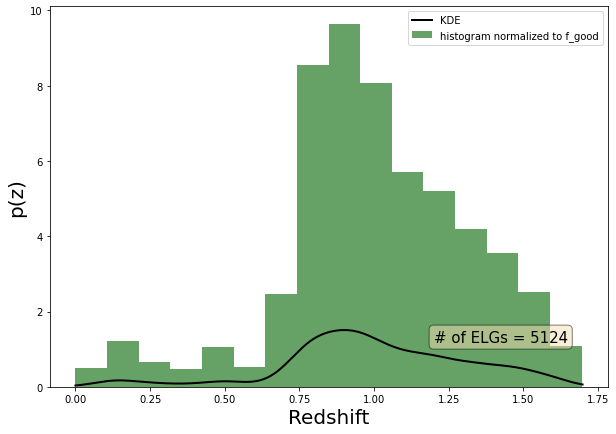

In [55]:
#use scipy to estimate the PDF using a Gaussian KDE
from scipy.stats import gaussian_kde

kernel = gaussian_kde(zelg)
zrange = np.arange(0., 1.7, .001)

plt.figure(figsize=(10,7))
#plt.plot(centr_z, pz_good, label = 'p(z) normalized to f_good', lw = 2)
#plt.plot(centr_z, pz_full, label = 'p(z) normalized to 1', lw = 2)
plt.plot(zrange, kernel(zrange)*f_good, c = 'black', lw = 2, label = 'KDE') #multiply by f_good because we want the PDF to account for missing redshifts, so the integral must be equal to f_good
plt.hist(zelg, bins = 16, weights = weights_fgood, alpha = 0.6, color = 'darkgreen', lw = 1.5, label = 'histogram normalized to f_good');
plt.legend(loc = 'best')
plt.xlabel("Redshift", fontsize = fs)
plt.ylabel("p(z)", fontsize = fs)
# For adding text
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(x = 1.2, y = 1.2, s = f'# of ELGs = {zelg.shape[0]}', fontsize = 15, bbox = props)

Verify that the ingeral is equal to $1$. 

In [22]:
#check integral
sp.integrate.trapz(kernel(zrange) * f_good, zrange, dx = 0.001)

0.9356344555183317

Convert $p(z)$ to $\frac{dn}{dz \cdot ddeg^2}$ 

In [39]:
#DESI forecast for comparison from FDR
redz_range = np.arange(0.65, 1.75, .1)
dndzddeg2 = np.array([309, 2269, 1923, 2094, 1441, 1353, 1337, 523, 466, 329, 126])

In [40]:
np.sum(weights_fgood * .1)

0.8475691580624867

In [194]:
#bins = 20
pz_full, bin_ledge = np.histogram(zelg, bins=[0, .125, .275, 0.425, 0.575, 0.725, 0.875, 1.025, 1.175, 1.325, 1.475, 1.625,
       1.775], density=True, range = (0., 1.8))

In [195]:
bin_ledge

array([0.   , 0.125, 0.275, 0.425, 0.575, 0.725, 0.875, 1.025, 1.175,
       1.325, 1.475, 1.625, 1.775])

In [196]:
num_density * pz_full

array([ 144.16649663,  189.78439774,   90.53934571,  132.32673604,
        287.28830851, 1873.46799973, 2040.61756104, 1316.30279535,
       1098.66013739,  827.04210025,  520.60123784,   36.56396654])

In [197]:
import pandas as pd

In [201]:
df = pd.DataFrame({'Redshift_Ledge' : bin_ledge[:-1], 'dndz/deg^2' : num_density * pz_full})
df

,Redshift_Ledge,dndz/deg^2
0,0.000,144.166497
1,0.125,189.784398
2,0.275,90.539346
3,0.425,132.326736
4,0.575,287.288309
5,0.725,1873.468000
6,0.875,2040.617561
7,1.025,1316.302795
8,1.175,1098.660137
9,1.325,827.042100


In [202]:
df.to_csv("nz_blanc.txt")

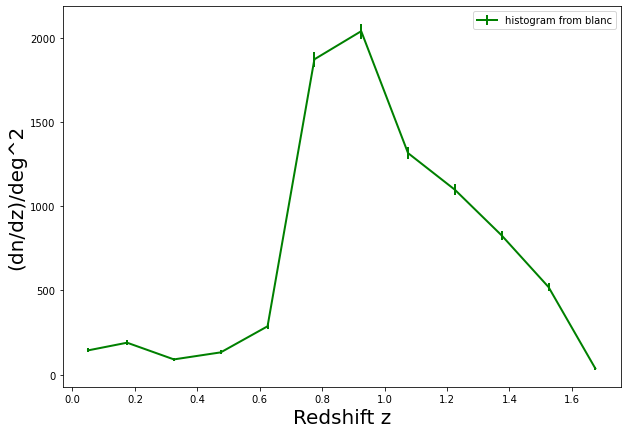

In [199]:
num_density = 1280 #per deg2
plt.figure(figsize=(10, 7))
#plt.hist(zelg, bins = 17, alpha = 0.6, density = True, label = 'Histogram')
#plt.plot(zrange, kernel(zrange) * f_good * 2400, c = 'black', lw = 2, label = 'KDE')
#plt.hist(zelg, bins = 16, weights = num_density * weights_fgood/5.5, alpha = 0.6, color = 'darkgreen', lw = 1.5, label = 'histogram normalized to f_good');
plt.errorbar(bin_ledge[:-1] + .05, num_density * pz_full, yerr = np.sqrt(num_density * pz_full), label = 'histogram from blanc', c = 'g', lw = 2) #Poisson error bar
#plt.errorbar(redz_range, dndzddeg2, yerr = np.sqrt(dndzddeg2), c = 'r', label = 'FDR forecast', lw = 2, alpha = 0.6)
plt.xlabel("Redshift z", fontsize = fs)
plt.ylabel("(dn/dz)/deg^2", fontsize = fs)
plt.legend(loc = 'best')

In [64]:
np.sum(dndzddeg2) * .1

1217.0

## Q5: What fraction of ELGs are also labelled as QSOs in each of the $5$ tiles?

In [34]:
def elg_classified_qso(tileid, data = sv1all, verbose = False):
    """Returns fraction of ELGs also labelled as QSOs for a given tile"""
    
    targetcol = 'SV1_DESI_TARGET'
    elgMask = desi_mask.mask('ELG_FDR_GFIB')
    qsoMask = desi_mask.mask('QSO')
    desi_target = sv1all[targetcol]
    
    #appropriate flags
    isGal = (sv1all['SPECTYPE'] == 'GALAXY')
    isRedshift = (sv1all['ZWARN'] == 0)
    istile = data['TILEID'] == tileid 
    
    #apply flags
    #first calculate numbers of ELG
    isELG = isGal & ((desi_target & elgMask) != 0) & istile
    isGoodRedzELG = isELG & isRedshift
    isNoRedzELG = isELG & (~isRedshift)
    
    isELGandQSO = isELG & ((desi_target & qsoMask) != 0)
    isGoodRedzELGandQSO = isELGandQSO & isRedshift
    isNoRedzELGandQSO = isELGandQSO & (~isRedshift)
    
    #calculate statistics
    frac_QSOELG = np.sum(isELGandQSO)/np.sum(isELG)
    frac_Good_QSOELG = np.sum(isGoodRedzELGandQSO)/np.sum(isGoodRedzELG)
    frac_NoZ_QSOELG = np.sum(isNoRedzELGandQSO)/np.sum(isNoRedzELG)
    
    if(verbose == True):
        print(f"fraction of ESOs also QSOs: {frac_QSOELG}")
        print(f"fraction of good redshift ESOs also QSOs: {frac_Good_QSOELG}")
        print(f"fraction of bad/no redshift ESOs also QSOs: {frac_NoZ_QSOELG}")
    
    return frac_QSOELG, frac_Good_QSOELG, frac_NoZ_QSOELG

In [35]:
frac_QSOELG = np.zeros(len(pure_elg_tiles))
frac_Good_QSOELG = np.zeros(len(pure_elg_tiles))
frac_NoZ_QSOELG = np.zeros(len(pure_elg_tiles))

for i in range(len(pure_elg_tiles)):
    frac_QSOELG[i], frac_Good_QSOELG[i], frac_NoZ_QSOELG[i] = elg_classified_qso(pure_elg_tiles[i])

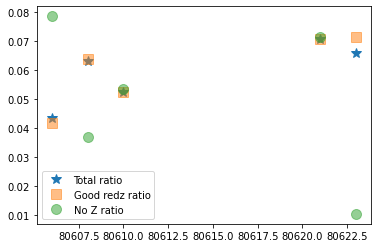

In [49]:
plt.plot(pure_elg_tiles, frac_QSOELG, ls = "", marker = "*", markersize = 10, label = "Total ratio")
plt.plot(pure_elg_tiles,frac_Good_QSOELG, ls = "", marker = "s", markersize = 10, alpha = 0.5, label = "Good redz ratio")
plt.plot(pure_elg_tiles,frac_NoZ_QSOELG, ls = "", marker = "o", markersize = 10, alpha = 0.5, label = "No Z ratio")
plt.legend(loc = 'best')

In [50]:
np.mean(frac_QSOELG)

0.059010919931061466

In [51]:
np.std(frac_QSOELG)

0.009825630588326875

Ashley Ross Code

In [209]:
import pandas as pd

fdr_gfib_nz_aross = pd.read_csv('/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/LSScats/v0/ELG_FDR_GFIBalltiles_deep_nz.dat', delimiter=" ", header=1)

In [210]:
area_aross = 8.0616 #deg2 

In [211]:
fdr_gfib_nz_aross

,#zmid,zlow,zhigh,n(z),Nbin,Vol_bin
0,0.015,0.01,0.02,0.028623,1,152.152310
1,0.025,0.02,0.03,0.000000,0,409.373418
2,0.035,0.03,0.04,0.011025,2,790.007150
3,0.045,0.04,0.05,0.006749,2,1290.501416
4,0.055,0.05,0.06,0.004567,2,1907.317624
...,...,...,...,...,...,...
154,1.555,1.55,1.56,0.000333,23,300975.291195
155,1.565,1.56,1.57,0.000216,15,301835.474529
156,1.575,1.57,1.58,0.000273,19,302679.995669
157,1.585,1.58,1.59,0.000187,13,303509.474867


In [227]:
np.diff(fdr_gfib_nz_aross['#zmid'])

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.

In [228]:
np.max(zelg)

1.695569323997275

In [241]:
fdr_gfib_nz_aross['zlow'].tail()

154    1.55
155    1.56
156    1.57
157    1.58
158    1.59
Name: zlow, dtype: float64

In [230]:
1.7/.01

170.0

In [247]:
bins = 170
pz_full, bin_ledge = np.histogram(zelg, bins = bins, range = (0., 1.7))

In [248]:
bin_ledge

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

In [250]:
fdr_gfib_nz_aross['zlow']

0      0.01
1      0.02
2      0.03
3      0.04
4      0.05
       ... 
154    1.55
155    1.56
156    1.57
157    1.58
158    1.59
Name: zlow, Length: 159, dtype: float64

In [261]:
pz_full[1:][bin_ledge[1:-1] <= 1.59].shape

(159,)

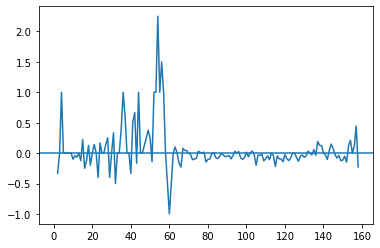

In [266]:
plt.plot((fdr_gfib_nz_aross['Nbin'] - pz_full[1:][bin_ledge[1:-1] <= 1.59])/pz_full[1:][bin_ledge[1:-1] <= 1.59])
plt.axhline(0)

In [267]:
np.sum(fdr_gfib_nz_aross['Nbin'])

4696

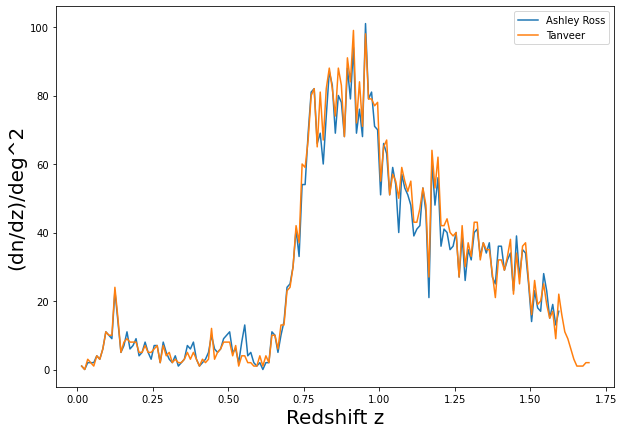

In [256]:
plt.figure(figsize=(10, 7))
plt.plot(fdr_gfib_nz_aross['#zmid'], fdr_gfib_nz_aross['Nbin'], label = 'Ashley Ross')
plt.plot(bin_ledge[1:-1] + .01/2, pz_full[1:], label = 'Tanveer')
plt.xlabel("Redshift z", fontsize = fs)
plt.ylabel("(dn/dz)/deg^2", fontsize = fs)
plt.legend(loc = 'best')

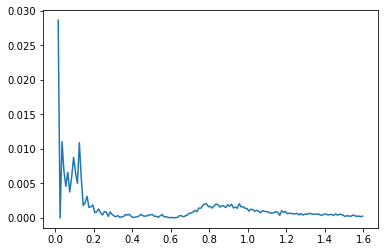

In [215]:
plt.plot(fdr_gfib_nz_aross['#zmid'], fdr_gfib_nz_aross['n(z)'], label )

In [218]:
from astropy.io import fits

In [220]:
tmp = fits.open("/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/blanc/v0/ELG/alltiles_ELGzinfo.fits")

In [226]:
tmp[1].data

(182043,)